# Optical depths

In [101]:
import pylab as plt
import numpy as np
from astropy.cosmology import Planck15
import astropy.constants as const
import astropy.units as u

import os

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')
plt.rc('figure', dpi=150)

In [30]:
Y_He = 0.24
nHI_0 = Planck15.Ob0 * Planck15.h * (1. - Y_He) / const.m_p.to(u.g)
print(nHI_0)

wave_Lya = 1216. * u.Angstrom
freq_Lya = (const.c / wave_Lya).to(u.Hz)

1.4958817907333172e+22 1 / g


# Lyman alpha cross-section, Voigt profile

In [158]:
def av(T):
    try:
        T = T.value
    except:
        pass
    return 4.7e-4 * (T/1.e4)**-0.5
    
def Voigt(x, T=1.e4):    
    phix = np.exp(-x**2.) + av(T)/np.sqrt(np.pi)/x**2.
    phix[phix > 1] = 1.
    return phix

def v_thermal(T=1.e4*u.K):
    return (1./np.sqrt(const.m_p/2./const.k_B/T)).to(u.km/u.s)

def Lya_crosssec(freq, T=1.e4, returnx=False):
    T         = T*u.K
    v_therm   = v_thermal(T)
    dfreq_Lya = (freq_Lya * v_therm / const.c).to(u.Hz)
    
    # Dimensionless frequency
    x = (freq - freq_Lya)/dfreq_Lya
    
    sig_Lya0 = 5.9e-14 * (T/1.e4/u.K)**-0.5
    sig_Lya  = sig_Lya0 * Voigt(x, T) * u.cm**2.
    
    if returnx:
        return x, sig_Lya
    else:
        return sig_Lya

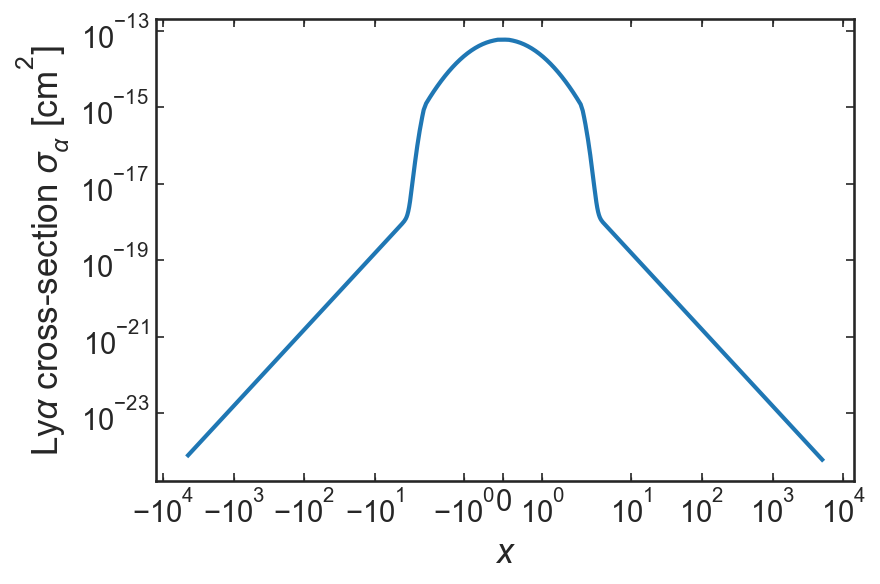

In [159]:
wave_range = np.linspace(1000, 1500, 100000)
freq_range = (const.c / wave_range/u.Angstrom).to(u.Hz)

x, sig_Lya = Lya_crosssec(freq_range, T=1e4, returnx=True)

plt.figure(figsize=(6,4))
plt.plot(x, sig_Lya)
plt.xlabel('$x$')
plt.ylabel(r'Ly$\alpha$ cross-section $\sigma_\alpha$ [cm$^2$]')

plt.xscale('symlog')
plt.yscale('log')

# Optical depth

In [129]:
def optical_depth_GP(z):
    return 7.e5 * ((1+z)/10.)**1.5

Text(0, 0.5, 'Gunn-Peterson IGM optical depth')

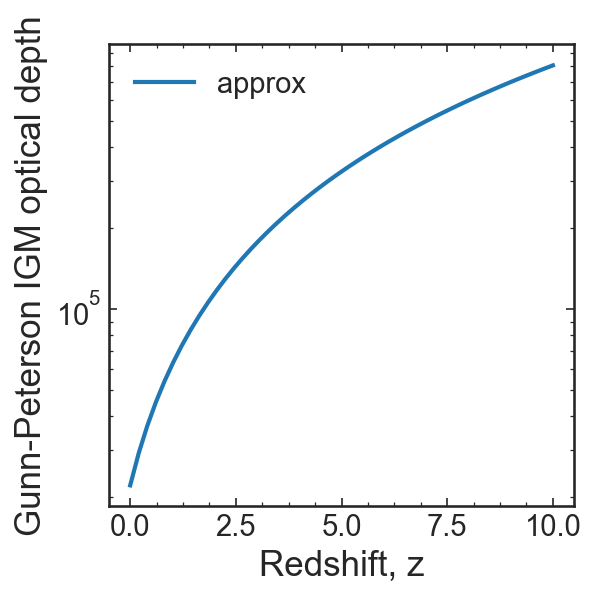

In [130]:
plt.semilogy(ztab, optical_depth_GP(ztab), label='approx')

plt.legend()

plt.xlabel('Redshift, z')
plt.ylabel('Gunn-Peterson IGM optical depth')

# Distance to neutral patches

In [164]:
def x_i(zg, R_i, DV=200.*u.km/u.s, T=1e4*u.K):
    """
    Dimensionless frequency distance to neutral patch at comoving distance R_i
    """
    return 1./-v_thermal(T) * (DV + Planck15.H(zg) * R_i/(1. + zg))

def optical_depth_damping(zg, R_b, R_e, DV=200.*u.km/u.s, T=1e4*u.K):
    return optical_depth_GP(zg)*av(T)/np.pi * (1./x_i(zg, R_e, DV=DV, T=T) - 1./x_i(zg, R_b, DV=DV, T=T))

Text(0, 0.5, 'x')

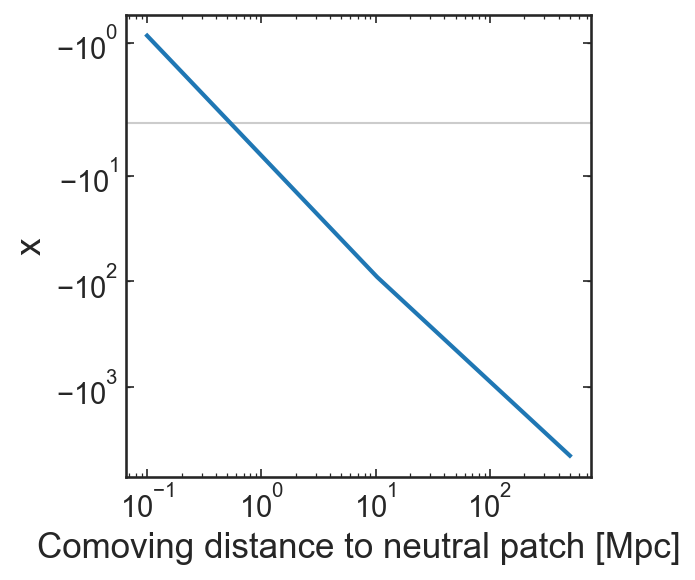

In [165]:
R_tab = np.linspace(0.1, 500)*u.Mpc

xi = x_i(zg=8., R_i=R_tab, DV=0.*u.km/u.s, T=1e4*u.K)

plt.plot(R_tab, xi)

plt.axhline(-3.2, lw=1, c='0.8', zorder=0)
plt.yscale('symlog')
plt.xscale('log')

plt.xlabel('Comoving distance to neutral patch [Mpc]')
plt.ylabel('x')

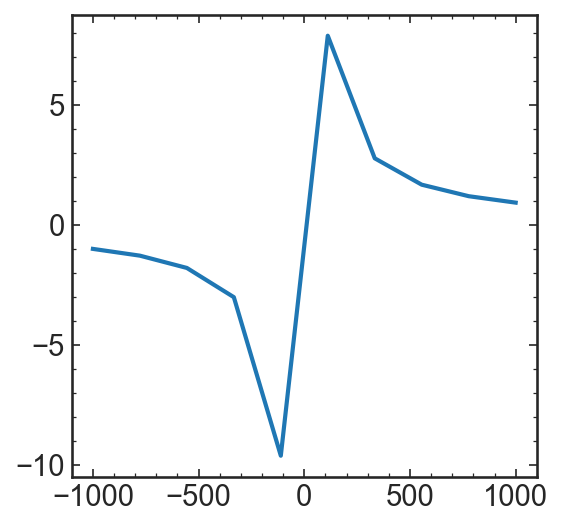

In [183]:
DV_tab = np.linspace(-1000., 1000, 10) * u.km/u.s
tau_d_tot = np.zeros(len(DV_tab))

for j,DV in enumerate(DV_tab):
    tau_d = np.zeros(len(R_tab)-1)
    for i in range(len(R_tab)-1):
        R_b = R_tab[i]
        R_e = R_tab[i+1]
        tau_d[i] = optical_depth_damping(zg=7., R_b=R_b, R_e=R_e, DV=DV, T=1e4*u.K)
    tau_d_tot[j] = np.sum(tau_d)   

plt.plot(DV_tab, tau_d_tot)

In [185]:
A_alpha = 6.25e8 / u.s # Einstein A coeff for Lya

def optical_depth_damping_approx(zg, xHI, DV_b):
    return optical_depth_GP(zg) / np.pi * xHI * A_alpha * wave_Lya/4./np.pi /DV_b


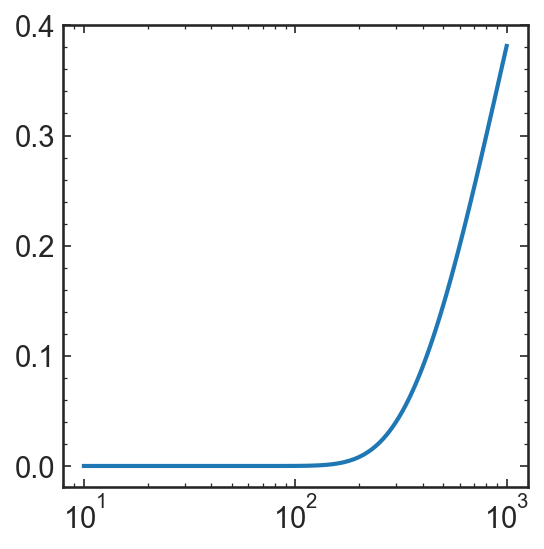

In [193]:
DV_tab = np.linspace(10., 1000, 100) * u.km/u.s
tau_D = optical_depth_damping_approx(zg=7., xHI=1., DV_b=DV_tab)

plt.semilogx(DV_tab, np.exp(-tau_D))